In [2]:
import os
import random
from time import time
from glob import glob
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from collections import Counter
import dill as pickle

from plotly import graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from matplotlib import pyplot as plt
%matplotlib inline

import cv2

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import fbeta_score, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T, models
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
#!pip install -q torchsummary --user
# from torchsummary import summary


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cpu


In [3]:
random.seed(101)
np.random.seed(101)
torch.manual_seed(101);

In [4]:
!ls /data2/ntua/data/planet/planet


fold_0.tfrecords  fold_3.tfrecords	 test-jpg
fold_1.tfrecords  fold_4.tfrecords	 train-jpg
fold_2.tfrecords  sample_submission.csv  train_classes.csv


In [5]:
path = "/data2/ntua/data/planet/planet"
path_train = os.path.join(path, "train-jpg")
path_test = os.path.join(path, "test-jpg")
print(
    f"train files: {len(os.listdir(path_train))}, "
    f"test files: {len(os.listdir(path_test))}"
)

train files: 40479, test files: 40669


In [6]:
path_class = os.path.join(path, "train_classes.csv")
df_class = pd.read_csv(path_class)
df_class = df_class.sample(n=2000) # limit images
print(df_class.shape)
df_class.head()

(2000, 2)


,image_name,tags
18906,train_18906,clear primary road water
30561,train_30561,agriculture clear primary
31870,train_31870,cloudy
37561,train_37561,clear primary
607,train_607,agriculture clear primary road


In [7]:
df_class["list_tags"] = df_class.tags.str.split(" ")
row_tags = df_class.list_tags.values
tags = [tag for row in row_tags for tag in row]
counter_tags = Counter(tags)
df_tags = pd.DataFrame(
    {"tag": counter_tags.keys(), "total": counter_tags.values()}
).sort_values("total")

fig = px.bar(df_tags, x="total", y="tag", orientation="h", 
             color="total",
)
fig.update_layout(title="Class distribution")
fig.show()

TypeError: '<' not supported between instances of 'dict_values' and 'dict_values'

In [8]:
RARE_CLASSES = [
    "bare_ground", "selective_logging", "artisinal_mine", "blooming", "slash_burn", "blow_down", "conventional_mine"
]

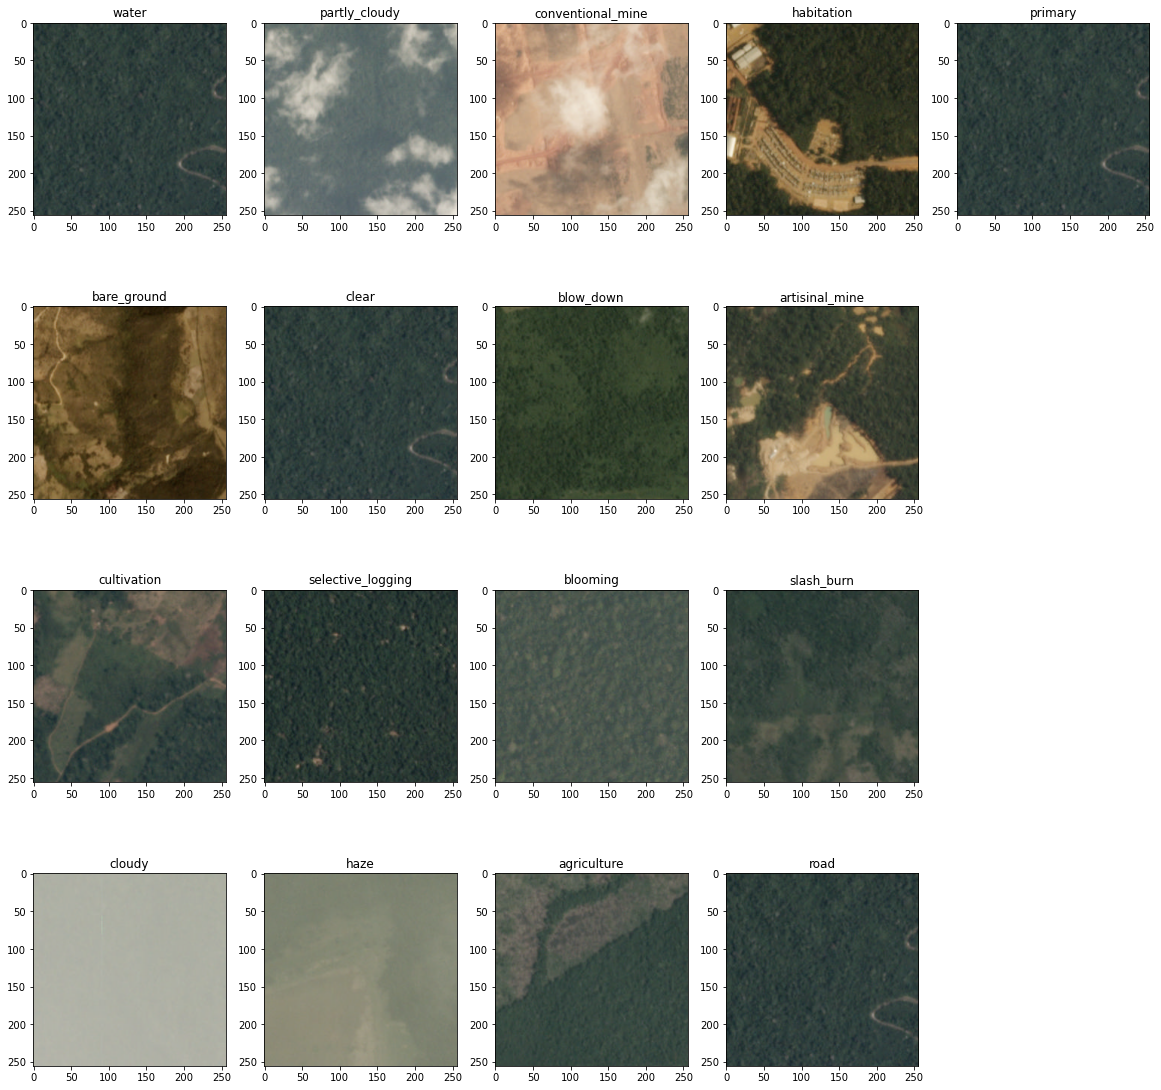

In [9]:
all_tags = list(set(tags))
N_tags = len(all_tags)
fig, axes = plt.subplots(4, (N_tags//4)+1, figsize=(20, 20))
for idx, tag in enumerate(all_tags):
    filename = df_class.loc[df_class.tags.str.contains(tag)].image_name.values[0]
    img = cv2.imread(os.path.join(path_train, filename+".jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    idx_col = idx // 4
    idx_row = idx % 4
    axes[idx_row][idx_col].set_title(tag)
    axes[idx_row][idx_col].imshow(img)
axes[1][-1].remove()
axes[2][-1].remove()
axes[3][-1].remove()

In [10]:
def load_img(path_file):
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (100, 100), cv2.INTER_LINEAR).astype(float)
    img = cv2.normalize(img, None, 0.0, 1.0, cv2.NORM_MINMAX)
    img = img.reshape(1, -1)
    return img

In [11]:
filenames = df_class.image_name.sample(600).values
#path_files = [os.path.join(path_train, filename+".jpg") for filename in filenames]
path_files = [os.path.join(path_train, filename+".jpg") for filename in filenames]
X_train_sample = np.vstack([load_img(path_file) for path_file in path_files])
X_train_sample.shape

(600, 30000)

In [12]:
tsne = TSNE(
    n_components=2,
    init="random",
    random_state=101,
    method="barnes_hut",
    n_iter=500,
    verbose=2,
)
X_embedded = tsne.fit_transform(X_train_sample)
X_embedded.shape

/data/miniconda3/envs/ntuaml4/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.016s...
[t-SNE] Computed neighbors for 600 samples in 0.138s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 7.249763
[t-SNE] Computed conditional probabilities in 0.078s
[t-SNE] Iteration 50: error = 74.4303589, gradient norm = 0.3981088 (50 iterations in 0.100s)
[t-SNE] Iteration 100: error = 77.9328766, gradient norm = 0.3512372 (50 iterations in 0.100s)
[t-SNE] Iteration 150: error = 82.8832169, gradient norm = 0.3379879 (50 iterations in 0.101s)
[t-SNE] Iteration 200: error = 81.0995407, gradient norm = 0.3585660 (50 iterations in 0.099s)
[t-SNE] Iteration 250: error = 82.5067978, gradient norm = 0.3468089 (50 iterations in 0.101s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.506798
[t-SNE] Iteration 300: error = 1.3389621, gradient norm = 0.0063964 (50 iterations in 0.103s)
[t-SNE] Iteration 350: error = 1.1339030, gradient norm = 0.0016193 (

(600, 2)

In [13]:
def fetch_img(path_file, h, w):
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (h*2, w*2), cv2.INTER_LINEAR)
    return img

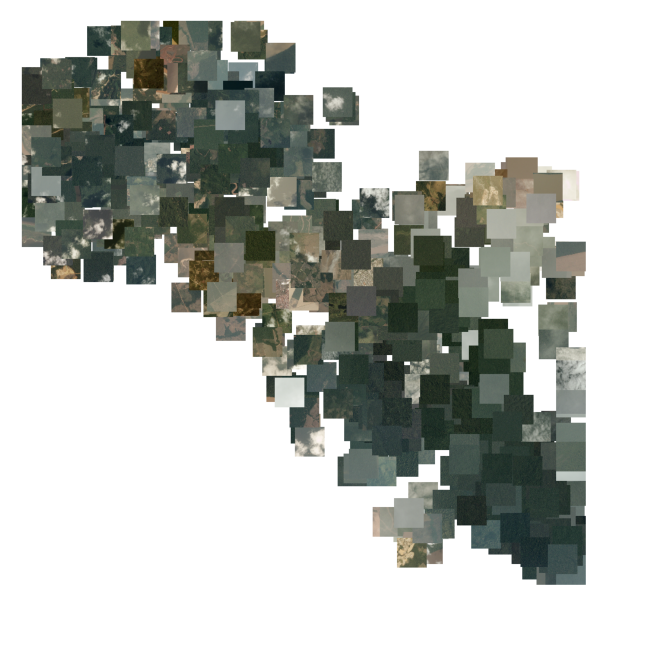

In [14]:
size_img = 1000
offset_img = 50
h = w = int(offset_img / 2)

X_scaled = (X_embedded - X_embedded.min(0)) / (X_embedded.max(0) - X_embedded.min(0))
X_scaled = (X_scaled * size_img).astype(int)
X_scaled = np.clip(X_scaled, offset_img, size_img-offset_img)

img_tsne = np.ones((size_img+2*offset_img, size_img+2*offset_img, 3), dtype=np.uint8) * 255
for idx in range(X_scaled.shape[0]):
    x, y = X_scaled[idx][0], X_scaled[idx][1]
    img = fetch_img(path_files[idx], h, w)
    img_tsne[x-w:x+w, y-h:y+h, :] = img

fig = plt.figure(figsize=(12, 12))
plt.imshow(img_tsne);
plt.axis("off");

In [15]:
def get_transforms():
    transform_train = T.Compose([
      T.ToPILImage(),
      T.Resize(224),
      T.ToTensor(),
      T.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225],
      )
    ])
    transform_val = T.Compose([
      T.ToPILImage(),
      T.Resize(224),
      T.ToTensor(),
      T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
      )
    ])
    return transform_train, transform_val

In [16]:
class AmazonDatasetError(Exception):
    pass


class AmazonDataset(Dataset):
    def __init__(self, df, ohe_tags, transform, path, is_train=True, idx_tta=None):
        super().__init__()
        self.df = df
        self.ohe_tags = ohe_tags
        self.transform = transform
        if isinstance(path, str):
            self.paths = [path]
        elif isinstance(path, (list, tuple)):
            self.paths = path
        else:
            raise AmazonDatasetError(f"Path type must be str, list or tuple, got: {type(path)}")
        self.is_train = is_train
        if not is_train:
            if not idx_tta in list(range(6)):
                raise AmazonDatasetError(
                    f"In test mode, 'idx_tta' must be an int belonging to [0, 5], got: {repr(idx_tta)}"
                )
            self.idx_tta = idx_tta

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx].image_name + ".jpg"
        for path in self.paths:
            if filename in os.listdir(path):
                file_path = os.path.join(path, filename)
                break
        else:
            raise AmazonDatasetError(f"Can't fetch {filename} among {self.paths}")
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.ohe_tags[idx]
        return img, label

    def collate_fn(self, batch):
        imgs, labels = [], []
        for (img, label) in batch:
            img = self.custom_augment(img)
            img = torch.tensor(img)
            img = img.permute(2, 0, 1)
            img = self.transform(img)
            imgs.append(img[None])
            labels.append(label)
        imgs = torch.cat(imgs).float().to(device)
        labels = torch.tensor(labels).float().to(device)
        return imgs, labels

    def load_img(self, idx, ax=None):
        img, ohe_label = self[idx]
        label = self.df.iloc[idx].tags
        title = f"{label} - {ohe_label}"
        if ax is None:
            plt.imshow(img)
            plt.title(title)
        else:
            ax.imshow(img)
            ax.set_title(title)
    
    def custom_augment(self, img):
        """
        Discrete rotation and horizontal flip.
        Random during training and non random during testing for TTA.
        Not implemented in torchvision.transforms, hence this function.
        """
        choice = np.random.randint(0, 6) if self.is_train else self.idx_tta
        if choice == 0:
            # Rotate 90
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_CLOCKWISE)
        if choice == 1:
            # Rotate 90 and flip horizontally
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_CLOCKWISE)
            img = cv2.flip(img, flipCode=1)
        if choice == 2:
            # Rotate 180
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_180)
        if choice == 3:
            # Rotate 180 and flip horizontally
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_180)
            img = cv2.flip(img, flipCode=1)
        if choice == 4:
            # Rotate 90 counter-clockwise
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_COUNTERCLOCKWISE)
        if choice == 5:
            # Rotate 90 counter-clockwise and flip horizontally
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_COUNTERCLOCKWISE)
            img = cv2.flip(img, flipCode=1)
        return img

In [17]:
def get_data(df_train, df_val):

    encoder = MultiLabelBinarizer()
    ohe_tags_train = encoder.fit_transform(df_train.list_tags.values)
    ohe_tags_val = encoder.transform(df_val.list_tags.values)

    transform_train, transform_val = get_transforms()
    ds_train = AmazonDataset(df_train, ohe_tags_train, transform_train, path=path_train)
    ds_val = AmazonDataset(df_val, ohe_tags_val, transform_val, path=path_train)

    dl_train = DataLoader(
      ds_train,
      batch_size=64,
      shuffle=True,
      collate_fn=ds_train.collate_fn
    )
    dl_val = DataLoader(
      ds_val,
      batch_size=64,
      shuffle=True,
      collate_fn=ds_val.collate_fn
    )

    return ds_train, ds_val, dl_train, dl_val, encoder

In [18]:
df_train, df_val = train_test_split(df_class, test_size=.2)

ds_train, ds_val, dl_train, dl_val, encoder = get_data(df_train, df_val)

imgs, labels = next(iter(dl_train))
imgs.shape, labels.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64, 17]))

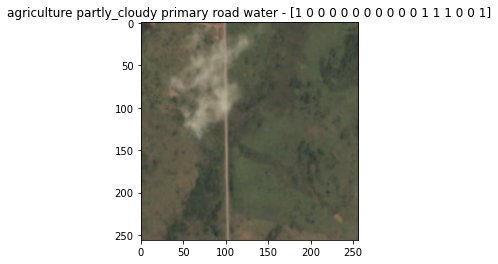

In [19]:
ds_train.load_img(15)

In [20]:
def get_model():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.require_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    model.fc = nn.Sequential(
      nn.Flatten(),
      nn.Linear(512, 128), # 512 for resnet18 or 2048 for resnet 50
      nn.ReLU(inplace=True),
      nn.Dropout(.2),
      nn.Linear(128, 17),
      nn.Sigmoid()
    )
    optimizer = Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.BCELoss()

    return model.to(device), optimizer, loss_fn

In [21]:
def train_batch(X, Y, model, loss_fn, optimizer):
    model.train()
    optimizer.zero_grad()
    Y_hat = model(X)
    batch_loss = loss_fn(Y_hat, Y)
    batch_loss.backward()
    optimizer.step()
    Y_hat = Y_hat.detach().float().cpu().numpy()
    
    return Y_hat, batch_loss.item()


@torch.no_grad()
def compute_val_loss(X, Y, model, loss_fn):
    model.eval()
    Y_hat = model(X)
    batch_loss = loss_fn(Y_hat, Y)
    Y_hat = Y_hat.detach().float().cpu().numpy()
    
    return Y_hat, batch_loss.item()

In [22]:

def train_model(dl_train, dl_val, idx_fold):
    model, optimizer, loss_fn = get_model()
    lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    loss_train, loss_val = [], []
    score_train, score_val = [], []

    Y_hat_val = None
    best_loss_val = np.inf

    epochs = 10
    for idx in range(epochs):
        loss_train_epoch, loss_val_epoch = [], []
        Y_hat_train_epoch, Y_hat_val_epoch = [], []
        Y_train_epoch, Y_val_epoch = [], []

        for X, Y in tqdm(dl_train, leave=False):
            Y_hat, batch_loss = train_batch(X, Y, model, loss_fn, optimizer)
            loss_train_epoch.append(batch_loss)
            Y_hat_train_epoch.extend(Y_hat)
            Y_train_epoch.extend(Y.detach().float().cpu().numpy())

        for X, Y in tqdm(dl_val, leave=False):
            Y_hat, batch_loss = compute_val_loss(X, Y, model, loss_fn)
            loss_val_epoch.append(batch_loss)
            Y_hat_val_epoch.extend(Y_hat)
            Y_val_epoch.extend(Y.detach().float().cpu().numpy())
                
        avg_loss_train = np.mean(loss_train_epoch)
        avg_loss_val = np.mean(loss_val_epoch)

        Y_hat_train_epoch = np.array(Y_hat_train_epoch)
        Y_hat_val_epoch = np.array(Y_hat_val_epoch)
        Y_thresh_train_epoch = (Y_hat_train_epoch > .2).astype(float)
        Y_thresh_val_epoch = (Y_hat_val_epoch > .2).astype(float)
        Y_train_epoch = np.array(Y_train_epoch)
        Y_val_epoch = np.array(Y_val_epoch)
        
        score_train_epoch = fbeta_score(Y_train_epoch, Y_thresh_train_epoch, beta=2, average="samples")
        score_val_epoch = fbeta_score(Y_val_epoch, Y_thresh_val_epoch, beta=2, average="samples")
               
        # saving values for debugging
        if avg_loss_val < best_loss_val:
            best_loss_val = avg_loss_val
            Y_hat_val = Y_hat_val_epoch
            Y_thresh_val = Y_thresh_val_epoch
            Y_val = Y_val_epoch
            
        loss_train.append(avg_loss_train)
        loss_val.append(avg_loss_val)
        score_train.append(score_train_epoch)
        score_val.append(score_val_epoch)

        print(
            f"epoch: {idx}/{epochs} -- train loss: {avg_loss_train}, " \
            f"val loss: {avg_loss_val}" \
            f" -- train fbeta_score: {score_train_epoch}, " \
            f"val fbeta_score: {score_val_epoch}"
        )
        
        lr_scheduler.step()

    train_results = {
        "loss_train": loss_train,
        "loss_val": loss_val,
        "score_train": score_train,
        "score_val": score_val,
        "Y_hat_val": Y_hat_val,
        "Y_thresh_val": Y_thresh_val,
        "Y_val": Y_val,
    }
        
    #torch.save(model, f"resnet18_fold{idx_fold}.pth")
    #pickle.dump(train_results, open(f"train_results_fold{idx_fold}.pkl", "wb"))
    return model, train_results, idx_fold

In [23]:
for rare_class in RARE_CLASSES:
    total_train = df_train.loc[df_train.tags.str.contains(rare_class)].shape[0]
    total_val = df_val.loc[df_val.tags.str.contains(rare_class)].shape[0]
    print(f"train {rare_class}: {100 * total_train / df_train.shape[0]:.4f}% ({total_train})")
    print(f"val {rare_class}: {100 * total_val / df_val.shape[0]:.4f}% ({total_val})\n")

train bare_ground: 2.2500% (36)
val bare_ground: 2.2500% (9)

train selective_logging: 0.8750% (14)
val selective_logging: 1.0000% (4)

train artisinal_mine: 0.9375% (15)
val artisinal_mine: 1.2500% (5)

train blooming: 0.6250% (10)
val blooming: 0.5000% (2)

train slash_burn: 0.3750% (6)
val slash_burn: 0.2500% (1)

train blow_down: 0.3750% (6)
val blow_down: 0.5000% (2)

train conventional_mine: 0.1875% (3)
val conventional_mine: 0.2500% (1)



In [ ]:
model, train_results, idx_fold = train_model(dl_train, dl_val, 0)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/noa/.cache/torch/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 0/10 -- train loss: 0.5523105204105377, val loss: 0.3974367550441197 -- train fbeta_score: 0.49234282940516594, val fbeta_score: 0.517919959813331


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 1/10 -- train loss: 0.3034387367963791, val loss: 0.22824070070471084 -- train fbeta_score: 0.6547537624880567, val fbeta_score: 0.8182378359555503


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 2/10 -- train loss: 0.19499728739261626, val loss: 0.16777057945728302 -- train fbeta_score: 0.8299533527848315, val fbeta_score: 0.8646851949571395


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 3/10 -- train loss: 0.15679013907909392, val loss: 0.14214726963213511 -- train fbeta_score: 0.8709603928115959, val fbeta_score: 0.8755221265250132


  0%|          | 0/25 [00:00<?, ?it/s]

In [24]:
torch.save(model, f"resnet18_fold{idx_fold}.pth")
pickle.dump(train_results, open(f"train_results_fold{idx_fold}.pkl", "wb"))

In [25]:
model = torch.load("resnet18_fold0.pth")
train_results = pickle.load(open("train_results_fold0.pkl", "rb"))

In [26]:
loss_train = train_results["loss_train"]
loss_val = train_results["loss_val"]
score_train = train_results["score_train"]
score_val = train_results["score_val"]

fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Fbeta scores"))
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_train))),
        y=loss_train,
        name="loss_train",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_val))),
        y=loss_val,
        name="loss_val",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(score_train))),
        y=score_train,
        name="score_train",
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(score_val))),
        y=score_val,
        name="score_val",
    ),
    row=1, col=2
)
fig.show()

In [27]:
Y_hat_val = np.array(train_results["Y_hat_val"])
Y_val = np.array(train_results["Y_val"])

pos_probas, neg_probas = [], []
for class_, idx in encoder._cached_dict.items():
    pos_probas.append(Y_hat_val[np.where(Y_val[:, idx] != 0), idx].mean())
    neg_probas.append(Y_hat_val[np.where(Y_val[:, idx] == 0), idx].mean())
go.Figure([
    go.Bar(x=list(encoder._cached_dict), y=pos_probas, name="Y_hat proba | Y = 1"),
    go.Bar(x=list(encoder._cached_dict), y=neg_probas, name="Y_hat proba | Y = 0")
]).show()

/tmp/ipykernel_23610/2289901735.py:6: RuntimeWarning:

Mean of empty slice.

/data/miniconda3/envs/ntuatf/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning:

invalid value encountered in true_divide



In [28]:
def find_best_thresholds(Y_hat, Y):
    N_tags = Y.shape[1]
    best_threshs = [0.2] * N_tags
    resolution = 100
    for jdx in tqdm(range(N_tags)):
        best_score = 0
        #threshs = np.zeros_like(best_threshs)
        threshs = best_threshs.copy()
        for kdx in range(resolution):
            kdx /= resolution
            threshs[jdx] = kdx
            Y_hat_thresh = (Y_hat > threshs).astype(float)
            score = fbeta_score(Y, Y_hat_thresh, beta=2, average="samples")
            if score > best_score:
                best_score = score
                best_threshs[jdx] = kdx
    
    global_best_score = fbeta_score(Y, (Y_hat > best_threshs).astype(float), beta=2, average="samples")
    print(f"threshs: {best_threshs} -- best score: {global_best_score}")
    
    return best_threshs

In [29]:
threshs = find_best_thresholds(Y_hat_val, Y_val)


threshs: [0.46, 0.36, 0.42, 0.45, 0.41, 0.39, 0.41, 0.37, 0.41, 0.31, 0.35, 0.4, 0.0, 0.47, 0.59, 0.43, 0.41] -- best score: 0.8254527781410566


In [30]:
class_scores = {}
classes = encoder.classes_
for jdx in range(Y_val.shape[1]):
    y_val = Y_val[:, jdx].ravel()
    y_hat_val = (Y_hat_val[:, jdx].ravel() > threshs[jdx]).astype(float)
    score = fbeta_score(y_val, y_hat_val, beta=2)
    class_scores[classes[jdx]] = round(score, 4)

df_score = pd.DataFrame(dict(
    label=list(class_scores.keys()), score=list(class_scores.values()),
)).sort_values("score", ascending=False)
fig = px.bar(df_score, x="label", y="score", color="score")
fig.show()

/data/miniconda3/envs/ntuatf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.

/data/miniconda3/envs/ntuatf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.

/data/miniconda3/envs/ntuatf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



In [31]:
fig = make_subplots(cols=5, rows=4)
for jdx in range(Y_val.shape[1]):
    y_val = Y_val[:, jdx].ravel()
    y_hat_val = (Y_hat_val[:, jdx].ravel() > threshs[jdx]).astype(float)
    tn, fp, fn, tp = confusion_matrix(y_val, y_hat_val).ravel()
    mat = np.array([[fn, tn], [tp, fp]])
    col = jdx // 4+1
    row = jdx % 4+1
    fig.add_trace(
        go.Heatmap(
            z=mat, text=[[f"fn: {fn}", f"tn: {tn}"], [f"tp: {tp}", f"fp: {fp}"]], 
            texttemplate="%{text}", colorscale='Viridis', name=encoder.classes_[jdx],
            showscale=False
        ),
        col=col, row=row, 
    )
    fig.update_xaxes(title=encoder.classes_[jdx], showticklabels=False, row=row, col=col)
    fig.update_yaxes(showticklabels=False, row=row, col=col)
    

fig.update_layout(
    width=1200, height=800, title="Confusion matrices", 
)
fig.show()

ValueError: not enough values to unpack (expected 4, got 1)

In [32]:
!echo $(ls /data2/ntua/data/planet/planet/test-jpg | wc -l) + $(ls /data2/ntua/data/test-jpg-additional/test-jpg-additional | wc -l)

40669 + 20522


In [57]:
def get_test_data(idx_tta):
    path_test_table = "/data2/ntua/data/planet/planet"
    path_test_file_1 = "/data2/ntua/data/planet/planet/test-jpg"
    path_test_file_2 = "/data2/ntua/data/test-jpg-additional/test-jpg-additional/"
    file_count = len(os.listdir(path_test_file_1)) + len(os.listdir(path_test_file_2))
    df_test = pd.read_csv(os.path.join(path_test_table, "sample_submission.csv"))
    df_test = df_test[0:2000] #limit images
    
    #assert df_test.shape[0] == file_count # sanity check
    
    ohe_tags_test = np.zeros((df_test.shape[0], 17))
    _, transform_val= get_transforms()
    ds_test = AmazonDataset(
        df_test, ohe_tags_test, transform_val, path=[path_test_file_1, path_test_file_2],
        is_train=False, idx_tta=idx_tta
    )
    ds_test = ds_test[0:2000] #limit images
    dl_test = DataLoader(
        ds_test, shuffle=False, batch_size=32, collate_fn=ds_test.collate_fn
    )
    
    return dl_test, df_test

In [58]:
@torch.no_grad()
def batch_predict(model, X):
    model.eval()
    Y = model(X)
    return Y.detach().float().cpu().numpy()

In [59]:
type(dl_test)

torch.utils.data.dataloader.DataLoader

In [60]:
Y_hat_test = []
for idx_tta in range(6):
    Y_hat_test_tta = []
    dl_test, df_test = get_test_data(idx_tta)
    for X, _ in tqdm(dl_test):
        Y_hat_test_batch = batch_predict(model, X)
        Y_hat_test_tta.extend(Y_hat_test_batch)
    Y_hat_test.append(Y_hat_test_tta)
Y_hat_test = np.mean(np.array(Y_hat_test), axis=0)
Y_hat_test = (Y_hat_test > threshs).astype(float)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
Y_hat_test_inv = encoder.inverse_transform(Y_hat_test)
test_tags = []
for row in Y_hat_test_inv:
    tags = " ".join(row)
    test_tags.append(tags)

df_test["tags"] = test_tags
df_test.to_csv("my_sample_submission.csv", index=False)